**Atharv** **Bajaj**


**20MA20014**

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [ ]:
stocks= pd.read_csv('/content/Dataset_Atharv_20MA20014.csv')

In [ ]:

def generate_random_weights(number_of_stocks): #Generates an array of random numbers whose sum is approximately equal to 1.

    random_values = np.random.uniform(0, 1, number_of_stocks)
    normalized_values = random_values / sum(random_values)
    return normalized_values


In [ ]:
child=generate_random_weights(49)
print(child,sum(child))

number_of_stocks = 49
initial_population_size = 200

# Generate the initial population
initial_population = np.array([generate_random_weights(number_of_stocks) for _ in range(initial_population_size)])


[4.08523779e-02 4.06962517e-02 1.24899334e-03 4.81955886e-03
 2.15456203e-02 6.87824378e-03 3.34141576e-03 2.03179463e-02
 1.07462856e-02 1.39151489e-02 3.74590000e-02 5.12096200e-03
 2.74387778e-02 1.06967399e-02 4.20009321e-02 1.16582419e-02
 1.32279110e-02 1.90295094e-02 7.27363364e-05 3.20876180e-02
 2.36808093e-02 3.39712305e-03 4.06480948e-03 1.42839593e-02
 2.57052058e-02 1.05800902e-02 2.52769740e-02 4.15387353e-02
 2.27110841e-02 1.23430792e-02 5.88648431e-03 2.97046747e-02
 1.36466947e-02 2.43724702e-02 1.87145670e-02 4.04657730e-02
 1.30991427e-02 1.81955903e-02 4.29169608e-02 3.91814517e-02
 3.41154718e-02 8.40045392e-03 4.29745654e-02 1.52228518e-02
 5.58905231e-03 3.96716120e-02 1.79046244e-02 1.05583347e-02
 3.26430837e-02] 1.0


In [ ]:
def retrieve_stock_data(month):
  return (stocks.iloc[month,1:])

def calculate_returns(stock_prices):
  return ((stocks.iloc[0,1:])-stock_prices)/stock_prices

def calculate_historical_returns(months_list):# This function computes historical stock returns for different specified months and returns a DataFrame.

    indices = []
    returns_df = pd.DataFrame()

    for month_value in months_list:
        stock_prices = retrieve_stock_data(month_value)
        returns = calculate_returns(stock_prices)
        print(type(returns))
        for x in range(len(returns)):
          if math.isinf(returns[x]):
            returns[x]=0
        indices.append(str(month_value) + '_days_returns')
        returns_df =pd.concat([returns_df, returns.to_frame().T], ignore_index=True)

    returns_df.index = indices
    return returns_df


In [ ]:
hist_stock_returns=calculate_historical_returns([5,13,21,29,35,41,49])


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
# method for converting columns to numeric data types
for col in hist_stock_returns.columns:
    hist_stock_returns[col] = pd.to_numeric(hist_stock_returns[col], errors='coerce')

covariance_matrix = hist_stock_returns.cov()

# Set the diagonal elements to zero for ease of calculations
np.fill_diagonal(covariance_matrix.values, 0)

mean_returns = hist_stock_returns.mean()

standard_deviation_returns = hist_stock_returns.std()


In [ ]:
def calculate_portfolio_mean_return(weights):
    return np.dot(weights, mean_returns)

def calculate_portfolio_variance(child_weights):
    return np.sum((child_weights * standard_deviation_returns) ** 2)+ np.sum(np.dot(np.dot(child_weights, covariance_matrix.values), child_weights))

risk_free_rate=0.0697

def calculate_sharpe_ratio(child_weights): #fitness function
    excess_return = calculate_portfolio_mean_return(child_weights) - risk_free_rate
    portfolio_std = np.sqrt(calculate_portfolio_variance(child_weights))
    sharpe_ratio = excess_return / portfolio_std if portfolio_std != 0 else 0  # To avoid division by zero
    return sharpe_ratio

def select_top_individuals(population, fraction=0.25): #Selects elite population from the total population based on fitness function values.

    population_fitness = [calculate_sharpe_ratio(x) for x in population]
    sorted_population_indices = np.argsort(population_fitness)[::-1]
    elite_population_indices = sorted_population_indices[:int(fraction * len(population))]
    elite_population = [population[i] for i in elite_population_indices]
    return elite_population

def mutate(parent_chromosome): # Randomly swaps elements within a chromosome to generate an offspring.

    child = parent_chromosome.copy()

    indices = np.random.choice(range(len(parent_chromosome)), 2, replace=False)
    child[indices[0]], child[indices[1]] = child[indices[1]], child[indices[0]]

    return child

def Arithmetic_crossover(parent1,parent2):
    ''' The oﬀsprings are created according to the equation:
            Off spring A = α ∗ Parent1 + (1 −α) ∗ Parent2
            Off spring B = (1 −α) ∗ Parent1 + α ∗ Parent2
            Where α is a random number between 0 and 1.
    '''
    alpha = np.random.rand()
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1,child2
def heuristic_crossover(parent1, parent2):
    '''
    Heuristic crossover generates offspring using fitness values and parent chromosomes.

    '''
    beta = np.random.rand()
    best_parent = parent1 if calculate_sharpe_ratio(parent1) > calculate_sharpe_ratio(parent2) else parent2
    worst_parent = parent1 if calculate_sharpe_ratio(parent1) <= calculate_sharpe_ratio(parent2) else parent2

    offspring_a = best_parent + beta * (best_parent - worst_parent)
    offspring_b = best_parent

    return offspring_a, offspring_b
def uniform_crossover(parent1, parent2):
    '''
    Uniform crossover generates two offspring by randomly selecting genes from parents.
    Input: Two parent chromosomes.
    Output: Two offspring (1D Arrays).
    '''
    mask1 = np.random.randint(2, size=len(parent1))  # Generating a random mask for child 1
    mask2 = np.random.randint(2, size=len(parent1))  # Generating a random mask for child 2

    child1 = np.where(mask1, parent1, parent2)  # Selecting genes for child 1 based on mask 1
    child2 = np.where(mask2, parent1, parent2)  # Selecting genes for child 2 based on mask 2

    return child1, child2




In [ ]:

def generate_next_generation(population_size, elite_population, crossover_function=Arithmetic_crossover):
    #Generates a new population by utilizing mutation and crossover operations on the elite population.


    new_population = []
    elite_indices = range(len(elite_population))

    while len(new_population) < population_size:
        mutate_crossover_prob = 0.6 if len(new_population) <= 2 * population_size / 3 else 0.1
        selected_operation = np.random.choice([0, 1], p=[1 - mutate_crossover_prob, mutate_crossover_prob])

        if selected_operation:
            index = np.random.choice(elite_indices)
            new_population.append(mutate(elite_population[index]))
        else:
            index_1, index_2 = np.random.choice(elite_indices, 2)
            child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            # Check for negative gene values in child_1
            if any(gene < 0 for gene in child_1):
                index_1, index_2 = np.random.choice(elite_indices, 2)
                child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            new_population.extend([child_1, child_2])

    return new_population

def generate_next_generation(population_size, elite_population, crossover_function=uniform_crossover):
    #Generates a new population by utilizing mutation and crossover operations on the elite population.


    new_population = []
    elite_indices = range(len(elite_population))

    while len(new_population) < population_size:
        mutate_crossover_prob = 0.6 if len(new_population) <= 2 * population_size / 3 else 0.1
        selected_operation = np.random.choice([0, 1], p=[1 - mutate_crossover_prob, mutate_crossover_prob])

        if selected_operation:
            index = np.random.choice(elite_indices)
            new_population.append(mutate(elite_population[index]))
        else:
            index_1, index_2 = np.random.choice(elite_indices, 2)
            child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            # Check for negative gene values in child_1
            if any(gene < 0 for gene in child_1):
                index_1, index_2 = np.random.choice(elite_indices, 2)
                child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            new_population.extend([child_1, child_2])

    return new_population

def generate_next_generation(population_size, elite_population, crossover_function=heuristic_crossover):
    #Generates a new population by utilizing mutation and crossover operations on the elite population.


    new_population = []
    elite_indices = range(len(elite_population))

    while len(new_population) < population_size:
        mutate_crossover_prob = 0.6 if len(new_population) <= 2 * population_size / 3 else 0.1
        selected_operation = np.random.choice([0, 1], p=[1 - mutate_crossover_prob, mutate_crossover_prob])

        if selected_operation:
            index = np.random.choice(elite_indices)
            new_population.append(mutate(elite_population[index]))
        else:
            index_1, index_2 = np.random.choice(elite_indices, 2)
            child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            # Check for negative gene values in child_1
            if any(gene < 0 for gene in child_1):
                index_1, index_2 = np.random.choice(elite_indices, 2)
                child_1, child_2 = crossover_function(elite_population[index_1], elite_population[index_2])

            new_population.extend([child_1, child_2])

    return new_population


In [ ]:
# Define variables for stock count and initial population size
number_of_stocks = 49
initial_population_size = 200
fit=[]
# Create the initial population
population = np.array([generate_random_weights(number_of_stocks) for _ in range(initial_population_size)])

# Obtain the initial elite population
elite_1 = select_top_individuals(population)

# Initialize variables for expected returns and risk
expected_returns_1 = 0
expected_risk_1 = 1

# Iterate through the evolutionary optimization loop
for iteration in range(50):
    population = generate_next_generation(200, elite_1,Arithmetic_crossover)
    elite_1 = select_top_individuals(population)
    fit.append(calculate_sharpe_ratio(elite_1[0]))
    expected_returns_1 = calculate_portfolio_mean_return(elite_1[0])
    expected_risk_1 = calculate_portfolio_variance(elite_1[0])

# Create the initial population
population = np.array([generate_random_weights(number_of_stocks) for _ in range(initial_population_size)])

# Obtain the initial elite population
elite_2 = select_top_individuals(population)
fit2=[]
# Initialize variables for expected returns and risk
expected_returns_2 = 0
expected_risk_2 = 1

# Iterate through the evolutionary optimization loop
for iteration in range(50):
    population = generate_next_generation(200, elite_2,uniform_crossover)
    elite_2 = select_top_individuals(population)
    fit2.append(calculate_sharpe_ratio(elite_2[0]))
    expected_returns_2 = calculate_portfolio_mean_return(elite_2[0])
    expected_risk_2 = calculate_portfolio_variance(elite_2[0])

# Create the initial population
population = np.array([generate_random_weights(number_of_stocks) for _ in range(initial_population_size)])

# Obtain the initial elite population
elite_3 = select_top_individuals(population)
fit3=[]
# Initialize variables for expected returns and risk
expected_returns_3 = 0
expected_risk_3 = 1

# Iterate through the evolutionary optimization loop
for iteration in range(50):
    population = generate_next_generation(200, elite_3,heuristic_crossover)
    elite_3 = select_top_individuals(population)
    fit3.append(calculate_sharpe_ratio(elite_3[0]))
    expected_returns_3 = calculate_portfolio_mean_return(elite_3[0])
    expected_risk_3 = calculate_portfolio_variance(elite_3[0])

Text(0, 0.5, 'Fitness Function (Sharpe Ratio)')

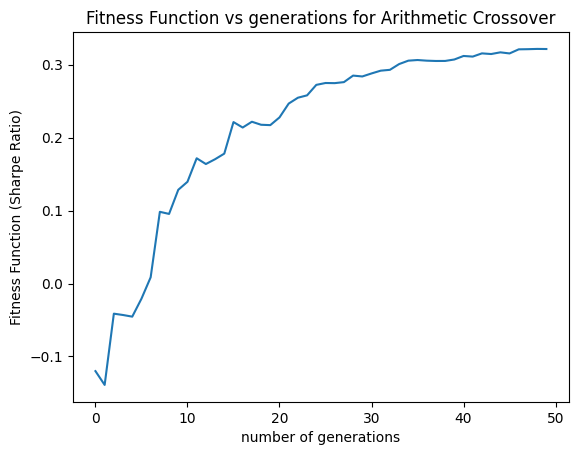

In [ ]:
plt.plot(fit)
plt.title("Fitness Function vs generations for Arithmetic Crossover")
plt.xlabel("number of generations")
plt.ylabel("Fitness Function (Sharpe Ratio)")

Text(0, 0.5, 'Fitness Function (Sharpe Ratio)')

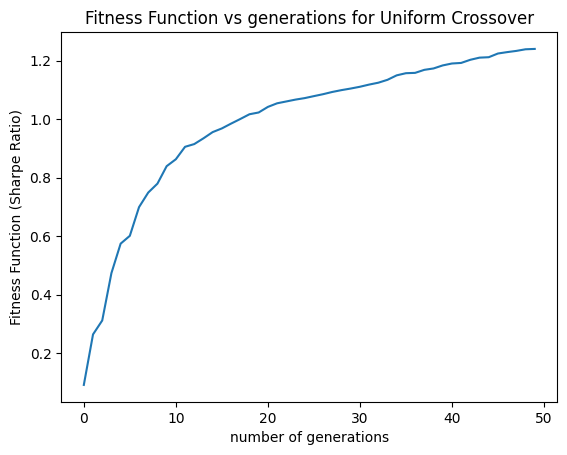

In [ ]:
plt.plot(fit2)
plt.title("Fitness Function vs generations for Uniform Crossover")
plt.xlabel("number of generations")
plt.ylabel("Fitness Function (Sharpe Ratio)")

Text(0, 0.5, 'Fitness Function (Sharpe Ratio)')

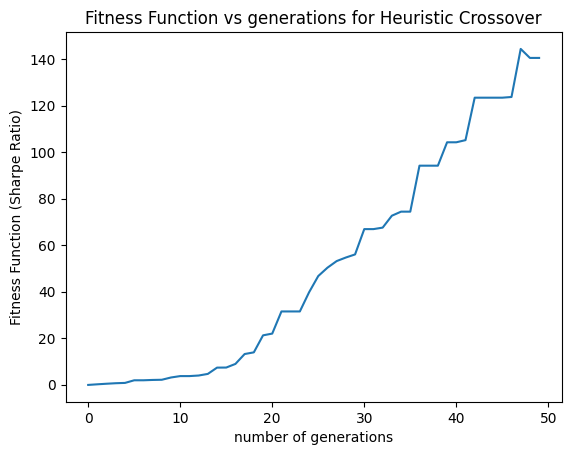

In [ ]:
plt.plot(fit3)
plt.title("Fitness Function vs generations for Heuristic Crossover")
plt.xlabel("number of generations")
plt.ylabel("Fitness Function (Sharpe Ratio)")

In [ ]:
rlt={'Returns':[expected_returns_1,expected_returns_2,expected_returns_3],
        'Risks':[expected_risk_1,expected_risk_2,expected_risk_3],
        'fitness(Sharpe Ratio)':[calculate_sharpe_ratio(elite_1[0]),calculate_sharpe_ratio(elite_2[0]),calculate_sharpe_ratio(elite_3[0])]
        }
result=pd.DataFrame(rlt, index=['Arithmetic_crossover',
                               'uniform_crossover',
                               'heuristic_crossover'
                              ])
result

,Returns,Risks,fitness(Sharpe Ratio)
Arithmetic_crossover,0.079697,9.680263e-04,0.321314
uniform_crossover,0.121261,1.727763e-03,1.240458
heuristic_crossover,0.191059,7.454182e-07,140.562907


In [ ]:
print('Final portfolio allocation for Arithmetic_crossover :\n')
weights_1=[]
for stock_index in range(49):
    print(hist_stock_returns.columns[stock_index],':',elite_1[0][stock_index])
    weights_1.append(elite_1[0][stock_index])



Final portfolio allocation for Arithmetic_crossover :

HDFCBANK : 0.0016791158096385046
IRCTC : 0.014438139209241701
DRREDDY : 0.01824511895158937
TCS : 0.007660997887219267
MFSL : 0.04185242943668159
GABRIEL : 0.04510969650821707
CONCOR : 0.014813747291190546
DMART : 0.009571817951897585
PERSISTENT : 0.03769573824397643
MPHASIS : 0.03793645630538857
SAFARI : 0.036142989695137386
INDUSTOWER : 0.00976242023797595
IDEA : 0.018979876795817124
RAYMOND : 0.02363249838537959
JPPOWER : 0.04277411425969682
ADANIPORTS : 0.0320231630131683
TIINDIA : 0.0013052986301773017
TRIVENI : 0.01408522317750356
BAJAJ : 0.0127298957425137
RUPA : 0.008117348395987307
VOLTAS : 0.029555583999469025
INDIGO : 0.008105883476011046
JPASSOCIAT : 0.00924335804864103
REDINGTON : 0.007465557289928219
PRESTIGE : 0.010561952202342104
ELECTCAST : 0.01178239156329718
ASHOKLEY : 0.017114385090322794
BDL : 0.01311672802727736
WIPRO : 0.015066024545950971
GREENPLY : 0.014413171860995172
SYRMA : 0.022842737057331114
UCOBANK :

In [ ]:
print('Final portfolio allocation uniform_crossover:\n')
weights_2=[]
for stock_index in range(49):
    print(hist_stock_returns.columns[stock_index],':',elite_2[0][stock_index])
    weights_2.append(elite_2[0][stock_index])



Final portfolio allocation uniform_crossover:

HDFCBANK : 0.00010312035597367651
IRCTC : 0.03869862973235176
DRREDDY : 0.03558884329345802
TCS : 0.004245126339588373
MFSL : 0.04699620131213859
GABRIEL : 0.04699620131213859
CONCOR : 0.002137917071398259
DMART : 0.009498050906073396
PERSISTENT : 0.04699620131213859
MPHASIS : 0.044924784484903314
SAFARI : 0.04699620131213859
INDUSTOWER : 0.006165063988004338
IDEA : 0.046104306960623176
RAYMOND : 0.044704729101490974
JPPOWER : 0.046104306960623176
ADANIPORTS : 0.04420036536744056
TIINDIA : 0.0019599991302217067
TRIVENI : 0.046104306960623176
BAJAJ : 0.006205682751142158
RUPA : 0.002137917071398259
VOLTAS : 0.04500404098519733
INDIGO : 0.005567020936328718
JPASSOCIAT : 0.03374480380618789
REDINGTON : 0.002137917071398259
PRESTIGE : 0.046104306960623176
ELECTCAST : 8.274504940191406e-05
ASHOKLEY : 0.009498050906073396
BDL : 0.008231349080889667
WIPRO : 0.006205682751142158
GREENPLY : 0.046104306960623176
SYRMA : 0.04699620131213859
UCOBANK :

In [ ]:
print('Final portfolio allocation heuristic_crossover:\n')
weights_3=[]
for stock_index in range(49):
    print(hist_stock_returns.columns[stock_index],':',elite_3[0][stock_index])
    weights_3.append(elite_3[0][stock_index])

Final portfolio allocation heuristic_crossover:

HDFCBANK : -0.04345011571749822
IRCTC : 0.07274541561929582
DRREDDY : 0.005962432436741281
TCS : 0.010048536886770517
MFSL : 0.16642911707432587
GABRIEL : 0.3407738419325443
CONCOR : 0.04917926223447628
DMART : -0.14431721547203663
PERSISTENT : -0.11868215807219294
MPHASIS : -0.2349649413206014
SAFARI : -0.019378037726840987
INDUSTOWER : 0.05981424177950031
IDEA : -0.05525081817925981
RAYMOND : -0.3281299409655447
JPPOWER : -0.07504573362519976
ADANIPORTS : -0.19327678173316087
TIINDIA : -0.13913699735992713
TRIVENI : 0.14202269808098109
BAJAJ : -0.06092397968838895
RUPA : -0.09480730643247755
VOLTAS : 0.1007649618015005
INDIGO : -0.45718977978772707
JPASSOCIAT : 0.14322648811357294
REDINGTON : 0.05220882422429344
PRESTIGE : -0.05472484860720967
ELECTCAST : -0.19103491679303405
ASHOKLEY : 0.03354229493340212
BDL : -0.08489149627793656
WIPRO : 0.06874630397016483
GREENPLY : -0.022295095286021572
SYRMA : 0.10042537451279854
UCOBANK : 0.384